# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [150]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

import pandas as pd
import numpy as np
import os

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

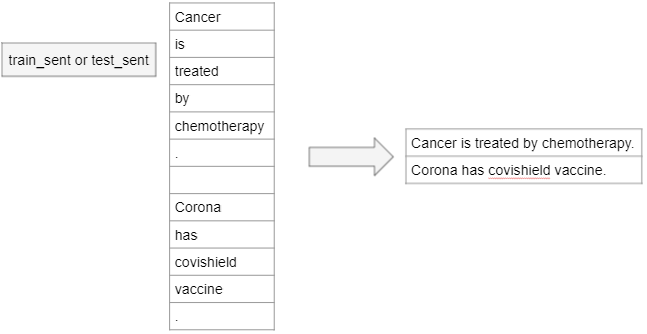

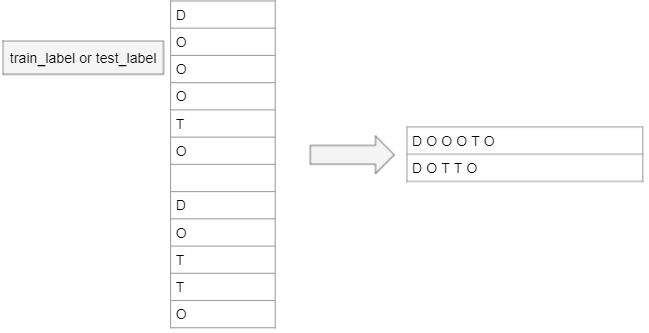

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
# function to create sentences from words in files
def form_sentences(filename):

  sentences = []
  with open("/content/drive/My Drive/NLP/" + filename,'r', encoding="utf-8") as file:
    sentence = []
    for line in file:
      word = line.strip()
      if word:
        sentence.append(word)
      else:
        if sentence:
          sentences.append(' '.join(sentence))
          sentence = []
    if sentence:  # Handle the last sentence if no blank line at the end
      sentences.append(' '.join(sentence))
  return sentences


In [153]:
# create array of sentences
train_sentences=form_sentences("train_sent")
train_labels=form_sentences("train_label")
test_sentences=form_sentences("test_sent")
test_labels=form_sentences("test_label")

In [154]:
# to see a specific sentence
train_sentences[20]

'Down syndrome ( 12 cases ) and Edward syndrome ( 11 cases ) were the most common trisomies , while 4 cases of Patau syndrome were also diagnosed'

In [155]:
# to see labels for a specific sentence
train_labels[20]

'D D O O O O O D D O O O O O O O O D O O O O O D D O O O'

In [156]:
# convert arrays to dataframes
df_train_sentences = pd.DataFrame(train_sentences)
df_train_labels = pd.DataFrame(train_labels)
df_test_sentences = pd.DataFrame(test_sentences)
df_test_labels = pd.DataFrame(test_labels)

In [157]:
# train sentences
df_train_sentences.head()

,0
0,All live births > or = 23 weeks at the Univers...
1,The total cesarean rate was 14.4 % ( 344 of 23...
2,Abnormal presentation was the most common indi...
3,The `` corrected '' cesarean rate ( maternal-f...
4,Arrest of dilation was the most common indicat...


In [158]:
# check coulmn data type
df_train_sentences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2599 entries, 0 to 2598
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2599 non-null   object
dtypes: object(1)
memory usage: 20.4+ KB


In [159]:
# change data type from object to string
df_train_sentences[0] = df_train_sentences[0].astype("string")
df_train_labels[0] = df_train_labels[0].astype("string")
df_test_sentences[0] = df_test_sentences[0].astype("string")
df_test_labels[0] = df_test_labels[0].astype("string")

In [160]:
df_train_sentences[0].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2599 entries, 0 to 2598
Series name: 0
Non-Null Count  Dtype 
--------------  ----- 
2599 non-null   string
dtypes: string(1)
memory usage: 20.4 KB


In [161]:
# train labels
df_train_labels.head()

,0
0,O O O O O O O O O O O O O O O O O O O O O O O ...
1,O O O O O O O O O O O O O O O O O O O O O O O O O
2,O O O O O O O O O O O O O O O
3,O O O O O O O O O O O O O O O O O O O O O O O ...
4,O O O O O O O O O O O O O O O O O O O O O O


In [162]:
# test sentences
df_test_sentences.head()

,0
0,"Furthermore , when all deliveries were analyze..."
1,"As the ambient temperature increases , there i..."
2,The daily high temperature ranged from 71 to 1...
3,There was a significant correlation between th...
4,Fluctuations in ambient temperature are invers...


In [163]:
# test labels
df_test_labels.head()

,0
0,O O O O O O O O O O O O O O O O O O O O O O O ...
1,O O O O O O O O O O O O O O O O O O O
2,O O O O O O O O O O O O O O O O O O O O O O O O
3,O O O O O O O O O O O O O O O O O O O O O O O ...
4,O O O O O O O O O O O


### Count the number of sentences in the processed train and test dataset

In [164]:
# Number of sentences in train data set
df_train_sentences.shape

(2599, 1)

In [165]:
# Number of sentences in test data set
df_test_sentences.shape

(1056, 1)

### Count the number of lines of labels in the processed train and test dataset.

In [166]:
# Number of labels in train data set
df_train_labels.shape

(2599, 1)

In [167]:
# Number of labels in test data set
df_test_labels.shape

(1056, 1)

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [168]:
# function to extract the pos tags for each token in each sentence. this function will extract only those workds with pos tag as 'NOUN' or 'PROPN'

def get_tokens(df_sent):
  tokens_pos = []

  # tokens_pos = [token.text for token in tokens if token.pos_ in ("NOUN", "PROPN")]

  for index, row in df_sent.iterrows():
    tokens = model(row[0])
    for token in tokens:
      if token.pos_ in('NOUN', 'PROPN'):
        tokens_pos.append([token.text, token.pos_])

  return tokens_pos

In [169]:
# call get_tokens for each sentence to extract pos tags for each word in each sentence
list_tokens = []
list_tokens = get_tokens(df_train_sentences)

In [170]:
df_tokens = pd.DataFrame(list_tokens)

In [171]:
df_tokens.head()

,0,1
0,births,NOUN
1,weeks,NOUN
2,University,PROPN
3,Vermont,PROPN
4,delivery,NOUN


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [172]:
# top 25 most common tokens with NOUN or PROPN
df_tokens.value_counts(ascending=False).nlargest(25)

,,count
0,1,
patients,NOUN,354
treatment,NOUN,195
%,NOUN,161
cancer,NOUN,135
therapy,NOUN,120
disease,NOUN,105
study,NOUN,103
cell,NOUN,99
lung,NOUN,86


## Defining features for CRF





In [173]:
import re
import nltk
from typing import Dict, List
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [174]:
# Let's define the features to get the feature value for one word.
# We have defined the following features for CRF model building:


def has_medical_suffix(word: str) -> bool:
    medical_suffixes = {
        'itis', 'emia', 'osis', 'pathy', 'plasty', 'ectomy',
        'otomy', 'ology', 'itis', 'gram', 'graph', 'oma'
    }
    return any(word.lower().endswith(suffix) for suffix in medical_suffixes)

def get_word_shape(word: str) -> str:
    shape = ''
    for char in word:
        if char.isupper():
            shape += 'A'
        elif char.islower():
            shape += 'a'
        elif char.isdigit():
            shape += '#'
        else:
            shape += char
    return shape

def check_medical_patterns(window: List[str]) -> Dict[str, bool]:
    text = ' '.join(window).lower()
    patterns = {
        'rate_of': 'rate of' in text,
        'risk_of': 'risk of' in text,
        'signs_of': 'signs of' in text,
        'symptoms_of': 'symptoms of' in text,
        'diagnosis_of': 'diagnosis of' in text,
        'treatment_with': 'treatment with' in text,
        'treated_with': 'treated with' in text
    }
    return patterns

def extract_features(sentence: str, position: int, window_size: int = 1) -> Dict:
    words = sentence.split()
    word = words[position]
    pos_tags = pos_tag(words)

    features = {
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word.shape': get_word_shape(word),
        'word_length': len(word),
        'word[-3:]' :  word[-3:],                                       # last three characters
        'word[-2:]' : word[-2:],

        'has_percentage': bool(re.search(r'\d+%', word)),
        'has_measurement': bool(re.search(r'\d+\s*(weeks|days|years)', word)),
        'medical_suffix': has_medical_suffix(word),
        'begins_capital': word[0].isupper() if word else False,

        'position': position,
        'is_start': position == 0,
        'is_end': position == len(words) - 1,
        'prev_bigram': f"{words[position-2]}_{words[position-1]}" if position > 1 else "<START>",
        'common_patterns': check_medical_patterns(words[max(0, position-2):position+1]),

        'prev_word': words[position - 1].lower() if position > 0 else '<START>',
        'next_word': words[position + 1].lower() if position < len(words) - 1 else '<END>',

        'pos': pos_tags[position][1],
        'prev_pos': pos_tags[position-1][1] if position > 0 else '<START>',
        'next_pos': pos_tags[position+1][1] if position < len(words)-1 else '<END>',
        'pos_pattern': f"{pos_tags[position-1][1]}_{pos_tags[position][1]}_{pos_tags[position+1][1]}" if 0 < position < len(words)-1 else '<NA>'
    }

    # This code creates a window of surrounding words as features.
    for i in range(-window_size, window_size + 1):
        if i != 0:
            idx = position + i
            if 0 <= idx < len(words):
                features[f'word_{i}'] = words[idx].lower()
            else:
                features[f'word_{i}'] = '<PAD>'

    return features


def create_feature_vectors(sentences: List[str]) -> List[List[Dict]]:
    all_features = []
    for sentence in sentences:
        words = sentence.split()
        sentence_features = []
        for i in range(len(words)):
            features = extract_features(sentence, i)
            sentence_features.append(features)
        all_features.append(sentence_features)
    return all_features

## Getting the features

### Write a code/function to get the features for a sentence

In [175]:
# code to get features for a trial(dummy) sentence.

tst_sentences = ["Testing with a dummy sentence. Assignment is to identify disease and treatement."]
tst_sentences_features = create_feature_vectors(tst_sentences)
tst_sentences_features

[[{'word.lower()': 'testing',
   'word.isupper()': False,
   'word.istitle()': True,
   'word.isdigit()': False,
   'word.shape': 'Aaaaaaa',
   'word_length': 7,
   'word[-3:]': 'ing',
   'word[-2:]': 'ng',
   'has_percentage': False,
   'has_measurement': False,
   'medical_suffix': False,
   'begins_capital': True,
   'position': 0,
   'is_start': True,
   'is_end': False,
   'prev_bigram': '<START>',
   'common_patterns': {'rate_of': False,
    'risk_of': False,
    'signs_of': False,
    'symptoms_of': False,
    'diagnosis_of': False,
    'treatment_with': False,
    'treated_with': False},
   'prev_word': '<START>',
   'next_word': 'with',
   'pos': 'VBG',
   'prev_pos': '<START>',
   'next_pos': 'IN',
   'pos_pattern': '<NA>',
   'word_-1': '<PAD>',
   'word_1': 'with'},
  {'word.lower()': 'with',
   'word.isupper()': False,
   'word.istitle()': False,
   'word.isdigit()': False,
   'word.shape': 'aaaa',
   'word_length': 4,
   'word[-3:]': 'ith',
   'word[-2:]': 'th',
   'has_p

In [176]:
# code to get features for a sentence from training sentences.

print([train_sentences[5]])
train_sentence_features = create_feature_vectors([train_sentences[5]])
train_sentence_features

['Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age']


[[{'word.lower()': 'cesarean',
   'word.isupper()': False,
   'word.istitle()': True,
   'word.isdigit()': False,
   'word.shape': 'Aaaaaaaa',
   'word_length': 8,
   'word[-3:]': 'ean',
   'word[-2:]': 'an',
   'has_percentage': False,
   'has_measurement': False,
   'medical_suffix': False,
   'begins_capital': True,
   'position': 0,
   'is_start': True,
   'is_end': False,
   'prev_bigram': '<START>',
   'common_patterns': {'rate_of': False,
    'risk_of': False,
    'signs_of': False,
    'symptoms_of': False,
    'diagnosis_of': False,
    'treatment_with': False,
    'treated_with': False},
   'prev_word': '<START>',
   'next_word': 'rates',
   'pos': 'JJ',
   'prev_pos': '<START>',
   'next_pos': 'NNS',
   'pos_pattern': '<NA>',
   'word_-1': '<PAD>',
   'word_1': 'rates'},
  {'word.lower()': 'rates',
   'word.isupper()': False,
   'word.istitle()': False,
   'word.isdigit()': False,
   'word.shape': 'aaaaa',
   'word_length': 5,
   'word[-3:]': 'tes',
   'word[-2:]': 'es',
   

In [177]:
#Code to get features for train and test sentences
X_train = create_feature_vectors(train_sentences)
X_test = create_feature_vectors(test_sentences)

In [178]:
X_train[5]

[{'word.lower()': 'cesarean',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'word.shape': 'Aaaaaaaa',
  'word_length': 8,
  'word[-3:]': 'ean',
  'word[-2:]': 'an',
  'has_percentage': False,
  'has_measurement': False,
  'medical_suffix': False,
  'begins_capital': True,
  'position': 0,
  'is_start': True,
  'is_end': False,
  'prev_bigram': '<START>',
  'common_patterns': {'rate_of': False,
   'risk_of': False,
   'signs_of': False,
   'symptoms_of': False,
   'diagnosis_of': False,
   'treatment_with': False,
   'treated_with': False},
  'prev_word': '<START>',
  'next_word': 'rates',
  'pos': 'JJ',
  'prev_pos': '<START>',
  'next_pos': 'NNS',
  'pos_pattern': '<NA>',
  'word_-1': '<PAD>',
  'word_1': 'rates'},
 {'word.lower()': 'rates',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'word.shape': 'aaaaa',
  'word_length': 5,
  'word[-3:]': 'tes',
  'word[-2:]': 'es',
  'has_percentage': False,
  'has_measurem

In [179]:
X_test[5]

[{'word.lower()': 'this',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'word.shape': 'Aaaa',
  'word_length': 4,
  'word[-3:]': 'his',
  'word[-2:]': 'is',
  'has_percentage': False,
  'has_measurement': False,
  'medical_suffix': False,
  'begins_capital': True,
  'position': 0,
  'is_start': True,
  'is_end': False,
  'prev_bigram': '<START>',
  'common_patterns': {'rate_of': False,
   'risk_of': False,
   'signs_of': False,
   'symptoms_of': False,
   'diagnosis_of': False,
   'treatment_with': False,
   'treated_with': False},
  'prev_word': '<START>',
  'next_word': 'study',
  'pos': 'DT',
  'prev_pos': '<START>',
  'next_pos': 'NN',
  'pos_pattern': '<NA>',
  'word_-1': '<PAD>',
  'word_1': 'study'},
 {'word.lower()': 'study',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'word.shape': 'aaaaa',
  'word_length': 5,
  'word[-3:]': 'udy',
  'word[-2:]': 'dy',
  'has_percentage': False,
  'has_measurement': Fal

### Write a code/function to get the labels of a sentence

In [180]:
# Write a code to get the labels for a sentence.
def getLabelsForOneSentence(labels):
    return labels.split()

example_labels = getLabelsForOneSentence(train_labels[5])
print(example_labels)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

### Define the labels as the target variable for test and the train dataset

In [181]:
Y_train = [getLabelsForOneSentence(labels) for labels in train_labels]
Y_test = [getLabelsForOneSentence(labels) for labels in test_labels]

## Build the CRF Model

In [182]:
# Build the CRF model.

crf_model = sklearn_crfsuite.CRF(max_iterations=300, keep_tempfiles=None)
try:
    crf_model.fit(X_train, Y_train)
except AttributeError:
    pass


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [183]:
Y_pred = crf_model.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [184]:
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print("F1 Score of the CRF model is: "+ str(round(f1_score*100,2))+ " %")

F1 Score of the CRF model is: 90.27 %


In [185]:
# Example test sentence and corresponding actual and predicted labels
index = 700
print("Sentence: ",test_sentences[index])
print("Actual labels:    ", Y_test[index])
print("Predicted labels: ", Y_pred[index])

Sentence:  New developments in the treatment of diabetes and hyperlipidemias
Actual labels:     ['O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'D']
Predicted labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D']


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

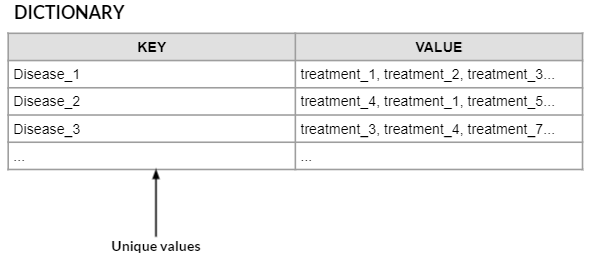

In [186]:
test_sentences[0:5]

['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )',
 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration',
 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period',
 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )',
 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']

In [187]:
len(test_sentences)

1056

In [188]:
Y_pred

array([list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
       list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
       list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
       ..., list(['T', 'T', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D']),
       list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D']),
       list(['T', 'T', 'T', 'O', 'O', 'O', 'O'])], dtype=object)

In [189]:
type(Y_pred)

numpy.ndarray

In [190]:
Y_pred.shape

(1056,)

In [191]:
test_sentences[1055]

'Intravenous immune globulin for recurrent spontaneous abortion'

In [192]:
print(test_sentences[73])
#(73, 2), (73, 3), (73, 18), (73, 19)
print(test_sentences[73].split())
print(test_sentences[73].split()[2])
print(Y_pred[73])

INTERPRETATION : Antichlamydial antibiotics may be useful in therapeutic intervention in addition to standard medication in patients with coronary-artery disease
['INTERPRETATION', ':', 'Antichlamydial', 'antibiotics', 'may', 'be', 'useful', 'in', 'therapeutic', 'intervention', 'in', 'addition', 'to', 'standard', 'medication', 'in', 'patients', 'with', 'coronary-artery', 'disease']
Antichlamydial
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D']


In [193]:
indices_T = []
indices_D = []
indices_D_T = []
disease_Treatment_Dict = {}
disease_array = []
treatment_array = []

for i, sublist in enumerate(Y_pred):
    t_found = False
    d_found = False
    disease_tuple = ()
    treatment_tuple = ()

    for j, element in enumerate(sublist):
        if element == 'T':
            indices_T.append((i, j))
            t_found = True
            treatment_tuple = treatment_tuple + (test_sentences[i].split()[j],)  # Wrap as a tuple
        if element == 'D':
            indices_D.append((i, j))
            d_found = True
            disease_tuple = disease_tuple + (test_sentences[i].split()[j],)  # Wrap as a tuple

    if t_found:
        treatment_array.append(treatment_tuple)

    if d_found:
        disease_array.append(disease_tuple)
        disease_str = " ".join(disease_tuple)  # Convert tuple to string
        treatment_list = list(treatment_tuple)  # Convert tuple to list

        # If the disease already exists in the dictionary, append treatments
        if disease_str in disease_Treatment_Dict:
            disease_Treatment_Dict[disease_str].extend(treatment_list)
        else:
            disease_Treatment_Dict[disease_str] = treatment_list  # Initialize with treatment list

    if t_found and d_found:
        indices_D_T.append(i)

print("Indices of T:", indices_T)
print("Indices of D:", indices_D)
print("Indices where both T and D occur:", indices_D_T)
print("Disease Array:", disease_array)
print("Treatment Array:", treatment_array)
print("Disease-Treatment Dictionary:")
print("---------------------------")
print(disease_Treatment_Dict)


Indices of T: [(46, 24), (61, 2), (71, 5), (99, 45), (99, 46), (99, 47), (99, 48), (99, 49), (99, 50), (99, 51), (113, 21), (113, 22), (114, 13), (114, 14), (115, 15), (128, 4), (151, 0), (151, 1), (151, 2), (151, 3), (151, 4), (151, 5), (155, 5), (155, 6), (155, 88), (155, 89), (155, 90), (162, 14), (185, 0), (185, 1), (186, 19), (186, 20), (186, 21), (186, 22), (189, 0), (189, 1), (189, 2), (208, 26), (209, 20), (209, 21), (210, 17), (210, 18), (216, 0), (216, 1), (217, 18), (217, 19), (217, 20), (217, 21), (217, 22), (217, 23), (217, 24), (217, 25), (241, 19), (241, 20), (241, 21), (241, 22), (254, 2), (254, 3), (258, 13), (258, 14), (258, 15), (258, 16), (258, 17), (258, 18), (277, 34), (277, 35), (285, 3), (297, 7), (297, 8), (297, 9), (297, 10), (297, 11), (297, 12), (297, 13), (373, 19), (419, 0), (419, 1), (433, 0), (433, 1), (433, 2), (438, 4), (461, 0), (461, 1), (468, 9), (468, 10), (468, 11), (468, 12), (470, 7), (510, 0), (510, 1), (513, 0), (513, 1), (550, 0), (550, 1), (

In [194]:
# Removing empty lists to obtain a cleaned version of "disease_treatment" dictionary
cleaned_dict = {}
for key in disease_Treatment_Dict.keys():
    if disease_Treatment_Dict[key] != []:
        cleaned_dict[key] = disease_Treatment_Dict[key]
cleaned_dict

{'hereditary retinoblastoma': ['radiotherapy'],
 'unstable angina or non-Q-wave myocardial infarction': ['roxithromycin'],
 'cerebral palsy': ['Hyperbaric', 'oxygen', 'therapy'],
 'cardiac disease': ['fenfluramine-phentermine'],
 "early Parkinson 's disease": ['Ropinirole', 'monotherapy'],
 "abdominal tuberculosis Crohn 's disease": ['steroids'],
 'female stress urinary incontinence': ['surgical', 'treatment'],
 'preeclampsia ( proteinuric hypertension )': ['intrauterine',
  'insemination',
  'with',
  'donor',
  'sperm',
  'versus',
  'intrauterine',
  'insemination'],
 'severe acquired hyperammonemia cancer': ['organ',
  'transplantation',
  'and',
  'chemotherapy'],
 'malignant pleural mesothelioma': ['thoracotomy',
  ',',
  'radiotherapy',
  ',',
  'and',
  'chemotherapy'],
 'pulmonary symptoms attributable to their massively enlarging mediastinal teratomas': ['chemotherapy'],
 'non-obstructive azoospermia': ['testicular',
  'fine',
  'needle',
  'aspiration',
  '(',
  'TEFNA',
  '

In [195]:
# Converting dictionary to a dataframe
cleaned_df = pd.DataFrame({"Disease":cleaned_dict.keys(),"Treatments":cleaned_dict.values()})
cleaned_df.head()

,Disease,Treatments
0,hereditary retinoblastoma,[radiotherapy]
1,unstable angina or non-Q-wave myocardial infar...,[roxithromycin]
2,cerebral palsy,"[Hyperbaric, oxygen, therapy]"
3,cardiac disease,[fenfluramine-phentermine]
4,early Parkinson 's disease,"[Ropinirole, monotherapy]"


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [196]:
disease_Treatment_Dict['hereditary retinoblastoma']

['radiotherapy']

In [197]:
search_phrase = "hereditary retinoblastoma"

# Iterate through test_sent and check for the phrase
for idx, sentence in enumerate(test_sentences):
    if search_phrase.lower() in sentence.lower():  # case-insensitive search
        print(f"Found '{search_phrase}' at index {idx} in: {sentence}")


Found 'hereditary retinoblastoma' at index 46 in: < TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy
